# Soot Survivors Guide

Soot 是一个经历 20 年开发，但能支持的语法特性仍停留在 Java 8 的静态分析框架。最可气的是，其仓库 Wiki 写得惨不忍睹。诚然，Soot 经过这么多年的开发，已经成为了个非常庞大的系统，很难存在既有理解，又有时间的热心观众，但我还是想吐槽，我从未见过如此凌乱、无章法的 Tutorial。

Soot Survivors Guide 是将近十年前的简介 & 教程，里面讲的其实大部分是 “Soot 作为 Command Line Tool” 时的用法和概念理解。谁能想象十年过后，Soot 版本从 2.0 升到了 4.3，人们还是要看这篇教程入门。从另一个角度来想，这说明该工具 API 非常稳定。

这篇笔记不是教程，只是篇备忘录。

## 1. 基础概念

### i. Scene

首先是到处出现的 Scene，记录了几乎所有分析过程信息。Soot 中也提供了面向使用者的接口，可以设置要分析的 application class 们、设置主类、获取或设置调用图等等。

后面提及 intra-procedural 和 inter-procedural 的区别，也会提到 Scene，因为这两类分析能够从 Scene 中取出的信息不同。

### ii. Class

文中分成了三种 Class：argument class / application class / library class。

#### a. argument class

顾名思义，这个 argument 是 command argument 的 argument。

在 [Soot Wiki](https://github.com/soot-oss/soot/wiki/Introduction:-Soot-as-a-command-line-tool) 中，用了大篇幅给 argument：

```shell
> java -cp sootclasses-trunk-jar-with-dependencies.jar soot.Main -cp . -pp A B
```

后面的 A 和 B 就是 argument class。

#### b. application class

定义：application class 是被 Soot 解析 / 转换成最终输出的 class 们。

#### c. library class

被 application classes 引用 (import / reference) 到，但却不在 application classes 集合内的那些 class。

```
They are used in the analyses and transformations.
but are not themselves transformed or output.
```

### iii. Pack

Pack 在 Soot 中大概指的是 “一趟处理”。

| 简称 | 含义 |
|:-:|:-:|
|stp|Shimple 转换 pack|
|jop|Jimple 优化 pack|
|jap|Jimple “标签化” (annotation) pack|
|bb|Baf body 创建|

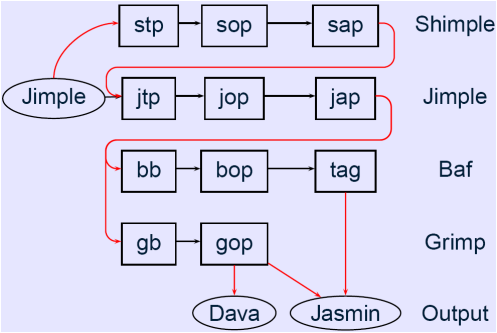

需要注意的是，这张图的输入是 “Jimple”，而不是源码。

而在过程间分析时，又多出了这样几个 pack：

| 简称 | 含义 |
|:-:|:-:|
|jb|Jimple body 创建|
|cg|调用图生成|
|wjtp|全 Jimple 转换 pack|
|wjop|全 Jimple 优化 pack|
|wjap|全 Jimple 标签化 pack|

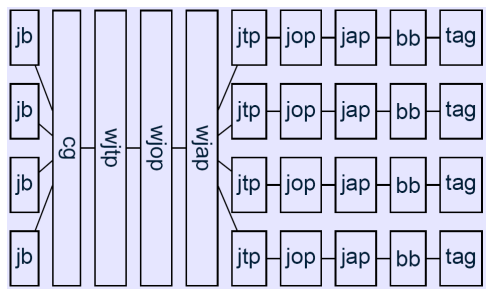

如文中所说，过程间分析与过程内分析的不同，就在于 “前者使所有的过程内分析时出现过的 pack，通过类似图中 wjap 的 ‘分发’ 后，都共享这些 pack 生成的程序信息”。

### iv. CLI-Tool 和 Compiler-Framework 的区别

其实应该没有。相较于 CLI-Tool 时加命令行参数（比如 -w），将 Soot 作为 Compiler-Framework，就是把加参数变成 Options.v().set_whole_program(true)：

```java
public class Test {
    public void main(String args[]) {
        Options.v().set_whole_program(true);
        /* some other configuration */
        Scene.v().loadNecessaryClasses();
        
        // 此后，就可以从 Scene 中获取所有信息
    }
}
```

## 2. 如何进行数据流分析

感觉好像暂时不是我需要关注的事，先放在这里。

## 3. 如何利用 CFG

感觉好像暂时不是我需要关注的事，先放在这里。

## 4. 如何生成调用图

调用图是调用边的集合。每个调用边 (Edge) 由以下四种元素组成：

* src (发起调用的方法)；
* srcUnit | srcStmt (发起调用的单元或语句)；
* tgt (被调用的方法)；
* Kind (调用边种类)。

### i. 获得调用图

可以通过 CallGraph 的 edgesInto / edgesOutOf 方法获得出边和入边。注意，下面的代码直接使用了 

```java
public class Test {
    public ArrayList<SootMethod> WhoCallMe(SootMethod target) {
        CallGraph cg = Scene.v().getCallGraph();
        ArrayList<SootMethod> res = new ArrayList<SootMethod>();

        // 存在 Sources(Iterator<Edge>) 的构造函数
        Sources s = new Sources(cg.edgesInto(target));
        while (s.hasNext()) {
            // s.next 返回 MethodOrMethodContext 接口类型，
            // SootMethod 实现了这个接口
            SootMethod m = (SootMethod)s.next();
            res.add(m);
        }
        return res;
    }
}
```

虽然默认用的是 CHA，但也还可能有些 method 没有 reach。所以可以通过 `getReachableMethods()` 获取可达方法集合。